In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import sys
import copy
import math
from os.path import join as oj
sys.path.insert(1, oj(sys.path[0], 'sentiment'))

from sentiment import sent_util
import tiling_text

import torch
from torchtext import data, datasets
import agglomerate_text
import visualize_text

from skimage import measure
from random import shuffle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load model

In [5]:
# get model
use_bad = False
# snapshot_dir = '/scratch/users/vision/chandan/data/saliency/train_subtrees'
# snapshot_dir = '/accounts/grad/jmurdoch/pytorch/agglomerative_attention/sentiment/results/'
# if use_bad:
#     snapshot_file = oj(snapshot_dir,
#                        'best_snapshot_bad_devacc_75.0_devloss_0.7053483128547668__iter_100_model.pt')
#     bad_model = sent_util.get_model(snapshot_file)
# else:
#     snapshot_file = oj(snapshot_dir, 
    #                     'best_snapshot_devacc_85.20642201834862_devloss_0.4385942220687866__iter_2000_model.pt')
#                       'best_snapshot_devacc_84.9770642202_devloss_0.536257088184__iter_4000_model.pt')
snapshot_file = '/scratch/users/vision/chandan/data/saliency/train_subtrees/best_snapshot_devacc_85.77981651376147_devloss_0.4260834753513336__iter_3000_model.pt'

model = sent_util.get_model(snapshot_file)
model.eval()

# get data
inputs, answers, train_iterator, dev_iterator = sent_util.get_sst()

loading /scratch/users/vision/chandan/data/saliency/train_subtrees/best_snapshot_devacc_85.77981651376147_devloss_0.4260834753513336__iter_3000_model.pt


/accounts/projects/vision/.local/lib/python3.5/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'model.LSTMSentiment' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/accounts/projects/vision/.local/lib/python3.5/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/accounts/projects/vision/.local/lib/python3.5/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by a

loaded onto gpu...


# useful functions

In [6]:
def agglomerate_and_save(method, batch, subtract, percentile_include, num_iters, 
                         sweep_dim, model, dset, absolute, fig_name=None, use_bad=False, 
                         wrong_preds=True, mturk=False, no_text=False):
    # output folder
    folder_name = 'class_diff' if subtract else 'max_class'
    out_dir = oj('out', method, folder_name, dset)
    if use_bad:
        out_dir = oj(out_dir, 'inaccurate')
    if wrong_preds:
        out_dir = oj(out_dir, 'wrong')
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    # get batch, text, label
    text_orig = [inputs.vocab.itos[int(ind)] for ind in batch.text.data]
    label_actual = int(batch.label) # 0 if positive 1 if negative
    scores_all = model(batch).data.cpu().numpy()[0]
    label_pred = np.argmax(scores_all)
    print('ex_num', fig_name, 'scores_all', scores_all, label_pred, label_actual)
    
    # sweep agglomerative
    lists = agglomerate_text.sweep_agglomerative(model, batch, percentile_include, method, sweep_dim, # only works for sweep_dim = 1
                        text_orig, label_pred, num_iters=num_iters, subtract=subtract, absolute=absolute)

    # visualize
    # visualize_text.visualize_scores(lists['scores_list'][0], label_pred, text_orig, 
    #                             lists['score_orig'], sweep_dim=1, method=method)
    # visualize_text.print_scores(lists, text_orig, num_iters)
    lists = agglomerate_text.collapse_tree(lists)

    visualize_text.word_heatmap(text_orig, lists, label_pred, label_actual, method, subtract, mturk, no_text)
    plt.savefig(oj(out_dir, fig_name + '.png'))
    
    viz_args = (text_orig, lists, label_pred, label_actual, method, subtract)
    return viz_args

def batch_from_str_list(s, inputs, train_iterator, dev_iterator):
    batch = sent_util.get_batches([0], train_iterator, dev_iterator)[0] # has batch.text, batch.label
    nums = np.expand_dims(np.array([inputs.vocab.stoi[x] for x in s]).transpose(),
                          axis=1)
    batch.text.data = torch.LongTensor(nums).cuda()
    return batch

# set parameters + generate examples

In [8]:
# base parameters
sweep_dim = 1
method = 'cd' # build_up, break_down, cd
ex_num = 309 #9
percentile_include = 90
num_iters = 25
subtract = True
dset = 'dev' # train, dev
absolute = True

wrong_preds = False
max_pred_diff = 0.3

if use_bad or wrong_preds:
    batch_nums = range(0, 700)
else:
    batch_nums = [309] # list(range(25)) + list(range(500, 525))

## generate real examples

getting batches...
found them all
ex_num 309 scores_all [ 1.7617487 -1.8049903] 0 1


sentiment/model.py:30: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  lstm_out, self.hidden = self.lstm(vecs, self.hidden)
/accounts/projects/vision/chandan/agglomerative_attention/agglomerate_text.py:85: RuntimeWarning: invalid value encountered in greater_equal
  mask = scores >= thresh
/accounts/projects/vision/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


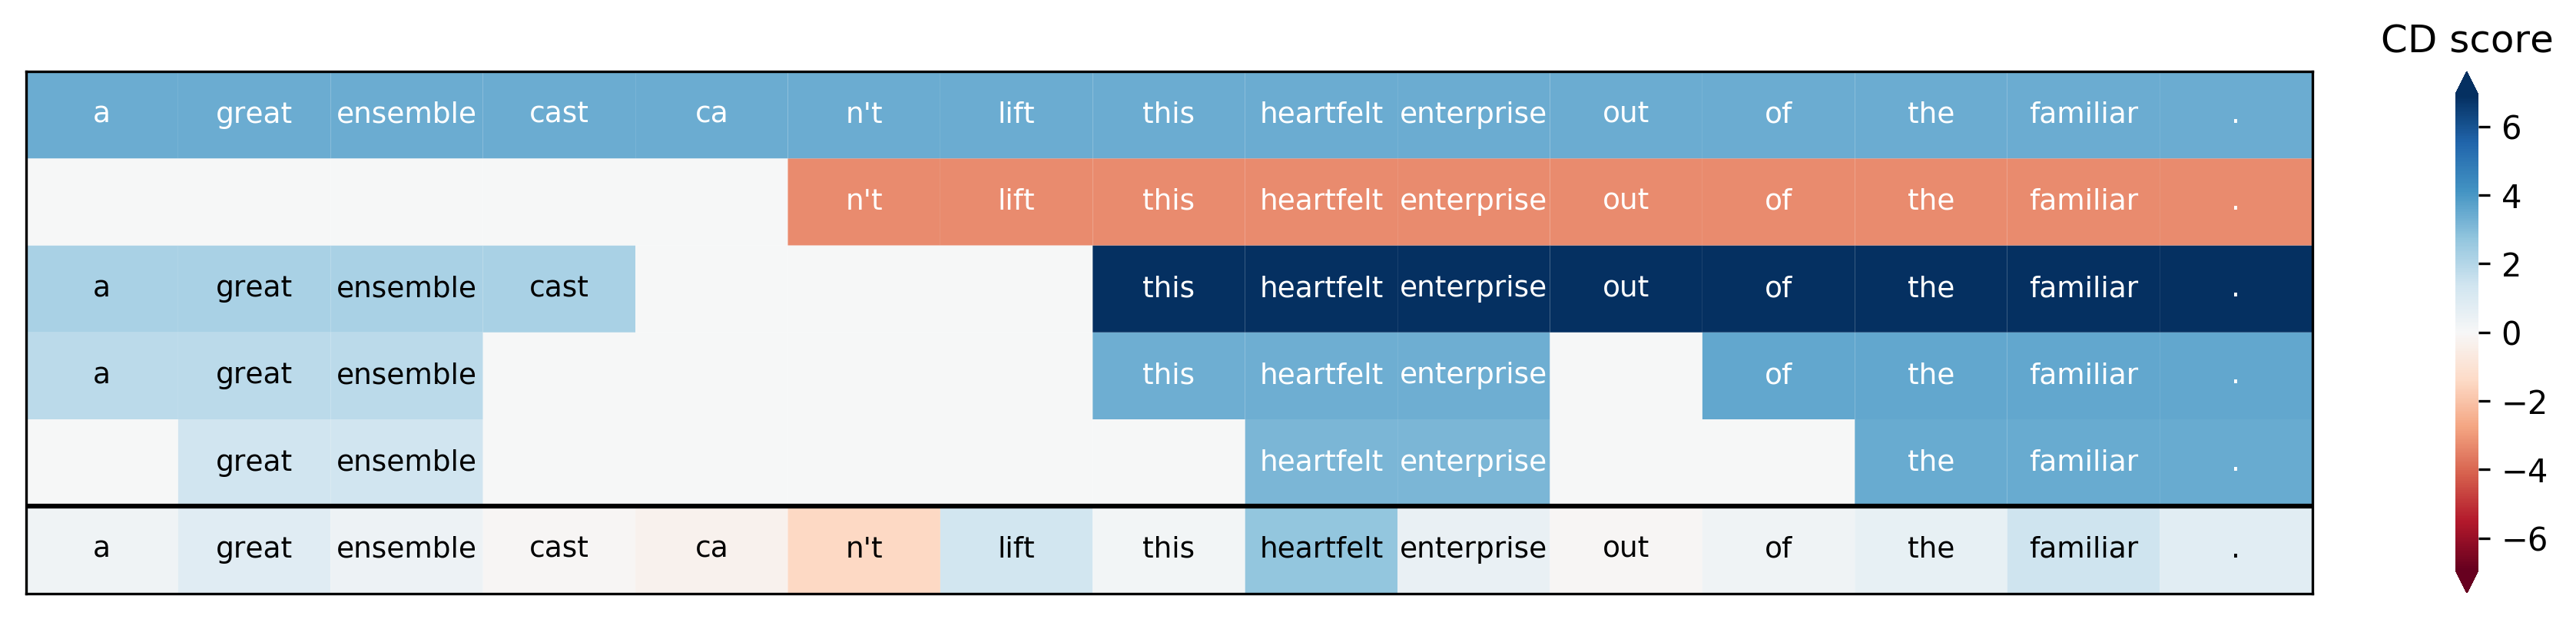

In [13]:
batches = sent_util.get_batches(batch_nums, train_iterator, dev_iterator, dset=dset) # has batch.text, batch.label
for method, ex_num, subtract in [(m, ex, sub) for m in ['cd']
                                 for ex in batch_nums # [ex_num]
                                 for sub in [True]
                                 for dset in ['dev']]: 
    batch = batches[ex_num]
    if wrong_preds:
        pred = model(batch).data[0]
        pred = pred[1] - pred[0]
        label = batch.label.data[0]
        if (pred < 0 and label == 1) or (pred > 0 and label == 0):
            agglomerate_and_save(method, batch, subtract, percentile_include, num_iters, 
                         sweep_dim, model, dset, absolute, fig_name=str(ex_num), wrong_preds=True)
    elif use_bad:
        good_pred = model(batch).data[0]
        good_pred = good_pred[1] - good_pred[0]
        bad_pred = bad_model(batch).data[0]
        bad_pred = bad_pred[1] - bad_pred[0]
        if abs(bad_pred - good_pred) < max_pred_diff:
            print(bad_pred, good_pred, ex_num)
            agglomerate_and_save(method, batch, subtract, percentile_include, num_iters, 
                         sweep_dim, model, dset, absolute, fig_name=str(ex_num), use_bad=False)
            agglomerate_and_save(method, batch, subtract, percentile_include, num_iters, 
                         sweep_dim, bad_model, dset, absolute, fig_name=str(ex_num), use_bad=True)
    else:
        agglomerate_and_save(method, batch, subtract, percentile_include, num_iters,
                         sweep_dim, model, dset, absolute, fig_name=str(ex_num), no_text=True)

## custom examples

getting batches...
found them all
ex_num not_good_,_not_bad_,_just_okay scores_all [ 0.4446826 -0.5871694] 0 1


sentiment/model.py:30: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  lstm_out, self.hidden = self.lstm(vecs, self.hidden)
/accounts/projects/vision/chandan/agglomerative_attention/agglomerate_text.py:85: RuntimeWarning: invalid value encountered in greater_equal
  mask = scores >= thresh
/accounts/projects/vision/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


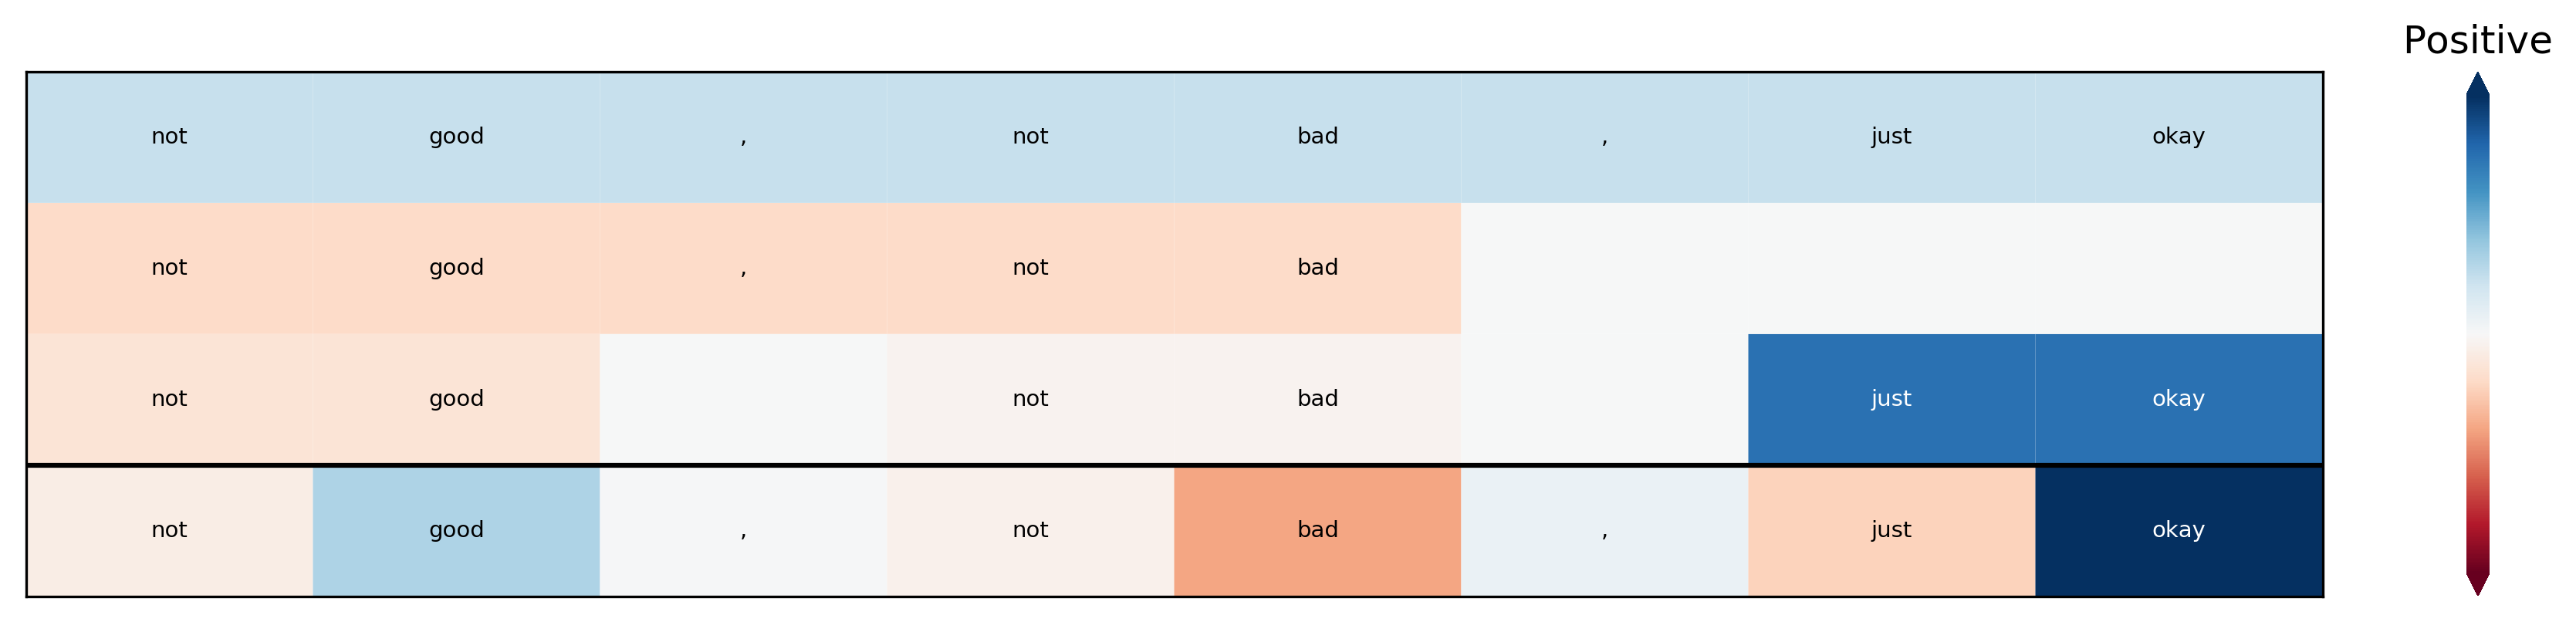

In [11]:
sentence_list = [
#                  ['this', 'incredibly', 'awful', 'movie', 'was', 'unbelievably', 'terrible'],
#                  ['this', 'movie', 'was', 'not', 'good'],
#                  ['not', 'a', 'good', 'movie'],
#                  ['idea', 'seemed', 'horrible', 'but', 'actually', 'good'],
#                  ['simple', 'yet', 'touching'],
                ['not', 'good', ',', 'not', 'bad', ',', 'just', 'okay'],
#                 ['opposite', 'of', 'good'],
#                 ['not', 'even', 'close', 'to', 'being', 'a', 'good', 'movie']
#                 ['not', 'very', 'good']
                ]
mturk = True
percentile_include = 99.5
no_text = True

for sentence in sentence_list:
    batch = batch_from_str_list(sentence, inputs, train_iterator, dev_iterator)
    label_actual = 1 # 0 if positive 1 if negative
    scores_all = model(batch).data.cpu().numpy()[0]
    label_pred = np.argmax(scores_all)

    agglomerate_and_save(method, batch, subtract, percentile_include, num_iters, 
                         sweep_dim, model, "custom", absolute, fig_name="_".join(sentence), mturk=mturk, no_text=no_text)